In [51]:
#####Heterogeneous Network ICAR Regression model##### 
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

In [52]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

(array([ 14.,  74., 178., 300., 410., 518., 581., 578., 647., 459., 356.,
        264., 193., 133., 101.,  74.,  60.,  27.,  16.,   5.,   5.,   4.,
          1.,   1.,   1.]),
 array([  7.  ,  11.12,  15.24,  19.36,  23.48,  27.6 ,  31.72,  35.84,
         39.96,  44.08,  48.2 ,  52.32,  56.44,  60.56,  64.68,  68.8 ,
         72.92,  77.04,  81.16,  85.28,  89.4 ,  93.52,  97.64, 101.76,
        105.88, 110.  ]),
 <a list of 25 Patch objects>)

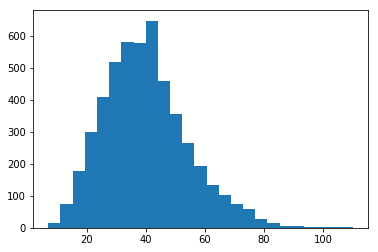

In [53]:
####データの発生####
##データの設定
type_n = 3
hh = 5000
pt = np.random.poisson(np.random.gamma(10.0, 1/0.25, hh), hh)
pt[pt <= 5] = 5
hhpt = np.sum(pt)
plt.hist(pt, bins=25)

In [54]:
##IDとインデックスを作成
#IDの作成
user_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [92]:
##ネットワークの設定
#ユーザーセグメントとパラメータを設定
seg = 7
theta = np.random.dirichlet(np.repeat(0.25, seg), hh)
Pi = np.random.beta(0.5, 12.0, seg*seg).reshape(seg, seg)
Z = np.array(np.zeros((hh, seg, type_n)), dtype="int")
z_vec = np.array(np.zeros((hh, type_n)), dtype="int")
for j in range(type_n):
    Z[:, :, j] = np.array(rmnom(theta, hh, seg, np.arange(hh)).todense())
    z_vec[:, j] = np.dot(Z[:, :, j], np.arange(seg))

#リンクと分散共分散行列の逆行列を定義
Q = np.array(np.zeros((hh, hh, type_n)), dtype="int16")
C = np.array(np.zeros((hh, hh, type_n)), dtype="float32")
for j in range(type_n):
    print(j)
    for i in range(hh):
        Prob = np.dot(Pi[z_vec[np.repeat(i, hh), j], ] * Z[:, :, j], np.repeat(1, seg))
        Q[i, :, j] = np.random.binomial(1, Prob, hh)
    Q[:, :, j] = -(np.triu(Q[:, :, j], k=1) + np.triu(Q[:, :, j], k=1).T) + np.diag(np.sum(Q[:, :, j], axis=1))
    C[:, :, j] = np.linalg.inv(Q[:, :, j])   #Qの逆行列を作成

0
1
2


In [111]:
##モデルパラメータを設定
#分散共分散行列を設定
tau = 0.25
Cov = np.array(np.zeros((hh, hh, type_n)), dtype="float32")
for j in range(type_n):
    Cov[:, :, j] = 1/tau * C[:, :, j]
mu = np.repeat(0, hh)

In [95]:
np.random.multivariate_normal(mu, Cov[:, :, 0], 1)

C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


array([[-0.04600284,  0.31122713,  1.4804275 , ..., -0.53142   ,
         0.15673806,  0.3662598 ]])

In [94]:
np.linalg.inv(Q[:, :, 0][0:3, 0:3])

array([[0.00429185, 0.        , 0.        ],
       [0.        , 0.00259067, 0.        ],
       [0.        , 0.        , 0.00833333]])

In [96]:
np.min(Q[:, :, 0])

-1

In [119]:
Q = np.array([2, -1, -1, 0, -1, 3, -1, -1, -1, -1, 3, -1, 0, -1, -1, 2]).reshape(4, 4)
a = np.random.normal(0, 1, 4*hh).reshape(hh, 4)   

In [136]:
y = np.dot(np.linalg.cholesky(Q), a.T).T

In [137]:
pd.DataFrame(np.corrcoef(y.T))

,0,1,2,3
0,1.000000,-0.423420,-0.404144,0.010720
1,-0.423420,1.000000,-0.333302,-0.399518
2,-0.404144,-0.333302,1.000000,-0.414620
3,0.010720,-0.399518,-0.414620,1.000000


In [134]:
Q

array([[ 2, -1, -1,  0],
       [-1,  3, -1, -1],
       [-1, -1,  3, -1],
       [ 0, -1, -1,  2]])